In [1]:
import gymnasium as gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
from tqdm import tqdm
import os
os.chdir('..')

# Deep deterministic policy gradient (DDPG)

[Deterministic policy gradient paper](https://proceedings.mlr.press/v32/silver14.pdf)

[Deep deterministic policy gradient paper](https://arxiv.org/pdf/1509.02971.pdf)

[Implementation here](../scripts/ddpg.py)

- **Only applicable to *continuous* action spaces**
- In continuous action spaces, greedy policy improvement using $\underset{a'}{\mathrm{argmax}}\;Q(s',a'; \theta)$, becomes very problematic as it requires a global maximisation at every step
- Alternatively, we can use a deterministic policy function to approximate the best action and move the policy in the direction of the gradient of $Q$:
  - The critic, $Q(s,a;\theta^Q)$ is learned using the Bellman equation like in Q-learning/DQN
  - The actor, $\mu(s;\theta^\mu)$ is updated by applying the chain rule to the gradient of $Q$ (w.r.t. $\theta^\mu$). This is derived from the *Deterministic Policy Gradient Theorem*, [proven by Silver et al.](https://proceedings.mlr.press/v32/silver14.pdf):
    - $$\nabla_{\theta^\mu}\approx \mathbb{E}_{s\sim \rho^\beta}\left[\nabla_{\theta^\mu} Q(s,\mu(s;\theta^\mu);\theta^Q)\right]$$
    - $$=\mathbb{E}_{s\sim \rho^\beta}\left[\nabla_{a}Q(s,a|\theta^Q) \nabla_{\theta^\mu}\mu(s;\theta^\mu)\right]$$
- DDPG uses many of the same stabilizing techniques as in DQN
  - Experience replay
  - Target networks (for both actor and critic)
- DDPG typically learns off-policy, with an exploration policy $u'$ that adds noise sampled from a noise process $\cal{N}$
  - $$\mu'(s_t)=\mu(s_t|\theta_t^\mu) + \cal{N}$$

![ddpg](ddpg.png)

# Demos

In [28]:
def run_deterministic_policy_model(env, policy_model, gamma=1.0, num_episodes=1, seed=None):
    ep_returns = []
    for _ in range(num_episodes):
        ep_return = 0
        state = env.reset(seed=seed)[0]
        for t in count():
            action = policy_model.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_return += reward * gamma**t
            state = next_state
            if terminated or truncated:
                ep_returns.append(ep_return)
                break
    return ep_returns

## Pendulum

In [19]:
import pickle
from scripts.ddpg import FCDP, FCQV
res = {}
with open('testfiles/ddpg_pendulum.results', 'rb') as file:
    res = pickle.load(file)

Text(0.5, 1.0, 'Total return')

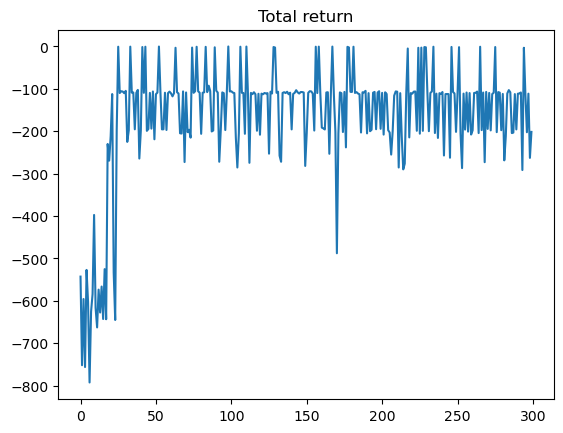

In [20]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), episode_returns)
plt.title('Total return')

Text(0.5, 1.0, 'Moving average of total return (k=100)')

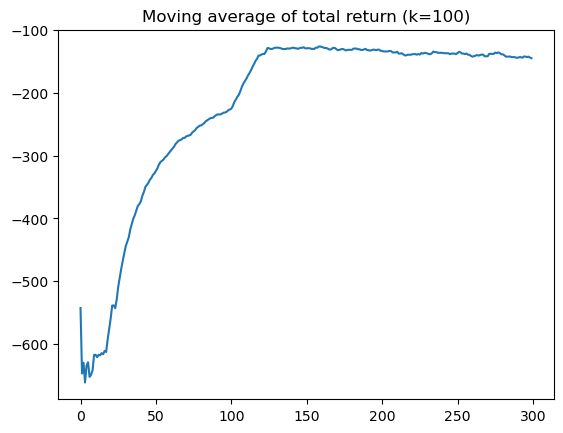

In [21]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), [np.mean(episode_returns[max(0,x-100):x+1]) for x in range(len(episode_returns))])
plt.title('Moving average of total return (k=100)')

In [27]:
env = gym.make("Pendulum-v1", render_mode='human')
run_deterministic_policy_model(env, res['best_model'], seed=42)
env.close()

In [30]:
import pygame
env = gym.make("Pendulum-v1", render_mode='human')
for k, v in res['saved_models'].items():
    print(f'Model at episode {k}')
    pygame.display.set_caption(f'Model at episode {k}')
    run_deterministic_policy_model(env, v, seed=42)
env.close()

Model at episode 1
Model at episode 10
Model at episode 50
Model at episode 100
Model at episode 250


## Lunar Lander

In [58]:
import pickle
from scripts.ddpg import FCDP, FCQV
res = {}
with open('testfiles/ddpg_lunarlander_limit.results', 'rb') as file:
    res = pickle.load(file)

Text(0.5, 1.0, 'Total return')

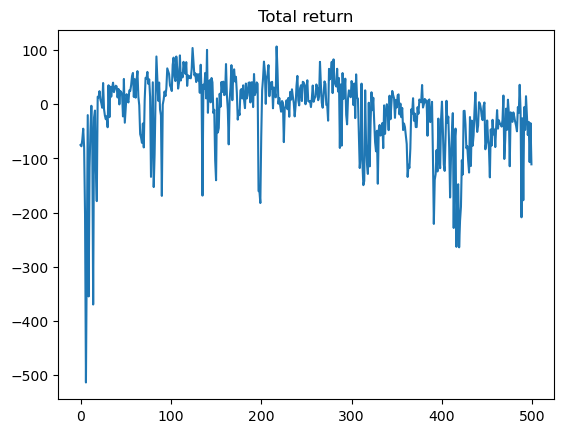

In [59]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), episode_returns)
plt.title('Total return')

Text(0.5, 1.0, 'Moving average of total return (k=100)')

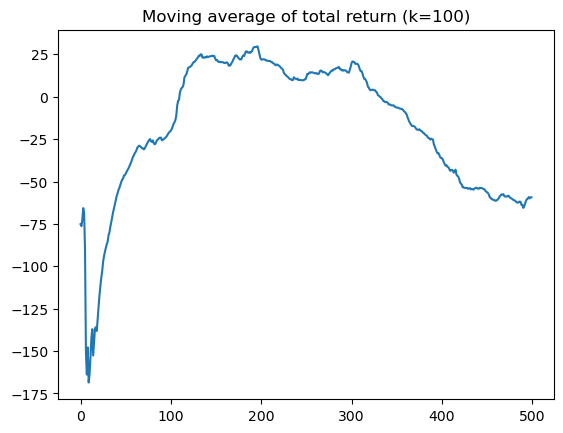

In [60]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), [np.mean(episode_returns[max(0,x-100):x+1]) for x in range(len(episode_returns))])
plt.title('Moving average of total return (k=100)')

In [61]:
env = gym.make("LunarLander-v2", continuous=True, render_mode='human')
run_deterministic_policy_model(env, res['best_model'])
env.close()

In [57]:
import pygame
env = gym.make("LunarLander-v2", continuous=True, render_mode='human')
for k, v in res['saved_models'].items():
    print(f'Model at episode {k}')
    pygame.display.set_caption(f'Model at episode {k}')
    run_deterministic_policy_model(env, v, seed=42)
env.close()

Model at episode 1
Model at episode 10
Model at episode 50
Model at episode 100
Model at episode 250
Model at episode 500
